In [73]:
import cv2
import numpy as np
import os
import time
import scipy.io as sio
import matplotlib.pyplot as plt
import math
# import main_functions as main

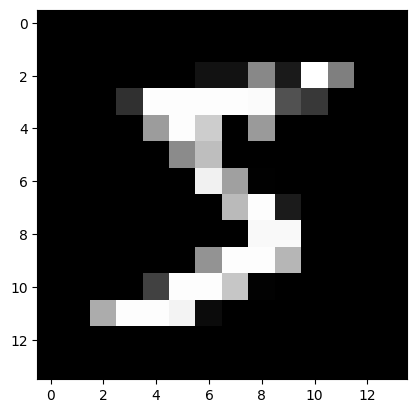

In [74]:
## Add for Visualization.
mnist_train = sio.loadmat('./mnist_train.mat')
mnist_test = sio.loadmat('./mnist_test.mat')
im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
im_test, label_test = mnist_test['im_test'], mnist_test['label_test']

np.random.seed(42)

plt.imshow(mnist_train['im_train'][:, 0].reshape((14, 14), order='F'), cmap='gray')

In [128]:
def get_mini_batch(im_train, label_train, batch_size):
    # TO DO
    ## One hot encode the labels.
    label_train_encoded = np.eye(10)[label_train[0]].T

    ## Get shuffled indices.
    np.random.seed(33)
    random_indices = np.random.permutation(label_train.shape[1])

    ## Get the Mini Batches, numpy automatically takes care of the last batch
    mini_batch_x = [im_train[:,random_indices[i*batch_size:(i+1)*batch_size]] for i in range(math.ceil(im_train.shape[1]/batch_size))]
    mini_batch_y = [label_train_encoded[:,random_indices[i*batch_size:(i+1)*batch_size]] for i in range(math.ceil(im_train.shape[1]/batch_size))]
    
    return mini_batch_x, mini_batch_y

In [76]:
def fc(x, w, b):
    # TO DO
    y = w@x + b
    return y

In [77]:
def fc_backward(dl_dy, x, w, b, y):
    # TO DO
    # print("Input to fc backward dl_dy: ", dl_dy.shape)
    # print("Input to fc backward x: ", x.shape)
    # print("Input to fc backward w: ", w.shape)
    # print("Input to fc backward b: ", b.shape)
    # print("Input to fc backward y: ", y.shape)
    dl_dw = dl_dy @ x.T
    dl_db = dl_dy
    dl_dx = w.T @ dl_dy
    
    return dl_dx, dl_dw, dl_db

In [78]:
def loss_euclidean(y_tilde, y):
    # TO DO
    l = np.sum(np.square(y_tilde - y))
    dl_dy = 2*(y_tilde - y)
    
    return l, dl_dy

In [130]:
def loss_cross_entropy_softmax(x, y):
    # TO DO
    ## Solve division by zero problem.
    x_max = np.max(x)
    ## Apply Softmax layer.
    y_telda = np.exp(x-x_max)/np.sum(np.exp(x-x_max))

    # Get the solfmax loss.
    l = -np.sum(y*np.log(y_telda + 1e-10))

    dl_dy = y_telda - y

    return l, dl_dy

In [80]:
def relu(x):
    # TO DO
    # print("Input to ReLU: ", x.shape)
    x[x < 0] = 0
    y = x
    # print("Output of ReLU: ", y.shape)
    return y

In [81]:
def relu_backward(dl_dy, x, y):
    # TO DO
    dl_dx = np.where(x > 0, dl_dy, 0)
    return dl_dx

In [82]:
def im2col(image, kernal_size, stride):
    # Assumes single channel input image.
    ## Shape of image : 16,16 padded is passed to this
    ## Set the number of patches as num of columns.
    num_cols = ((image.shape[0]-kernal_size)//stride +1)*((image.shape[1]-kernal_size)//stride + 1)

    col_image = np.empty((kernal_size*kernal_size, num_cols))
    col_index = 0
    for col in range(0, image.shape[1]-kernal_size+1, stride):
        for row in range(0, image.shape[0]-kernal_size+1, stride):
            patch = image[row:row+kernal_size, col:col+kernal_size]
            col_image[:,col_index] = patch.flatten(order='F')
            col_index+=1
    return col_image

In [83]:
def conv(x, w_conv, b_conv):
    # TO DO
    ## Pad the input image.
    # print("Shape of x : ", x.shape)  ## 14,14,1
    # print("Shape of w_conv : ", w_conv.shape) ## 3,3,1,3
    # print("Shape of b_conv : ", b_conv.shape)   ## 3,1

    ## Pad the imput image.
    x_padded = np.pad(x,((1,1),(1,1),(0,0)),mode='constant')  ## 16,16,1
    # print("Shape of x_padded : ", x_padded.shape)
    ## im2col Implementation.
    ## Create the col_image.
    kernal_size = 3
    stride = 1
    col_image = im2col(x_padded.reshape((x_padded.shape[0],x_padded.shape[1])), kernal_size, stride)  ## 9,196 (Channel assumed one here, as the output is 2D)

    ## Create flattned weights.
    w = np.reshape(w_conv, (3,9), order='F')  ## 3,9
    w = np.flip(w, axis=1)                    ## 3,9
 
    y = (w @ col_image).T                     ## 196, 3

    ## Reshape to image format.
    y = np.reshape(y,(14,14,3), order='F')
    # print("Shape of y output from conv : ", y.shape)
    return y

In [85]:
def conv_backward(dl_dy, x, w_conv, b_conv, y):
    # TO DO
    ## Pad the imput x.

    x_padded = np.pad(x, ((1,1),(1,1),(0,0)), mode='constant')
    # print("Shapeo of x : ", x.shape)
    # print("Shapeo of x_padded : ", x_padded.shape)
    # print("shape of w_conv input :", w_conv.shape)
    # print("shape of b_conv input :", b_conv.shape)

    ## Get the col Image.
    x_col = im2col(x_padded,3,1)        ## 9,196
    # print('shape of x_col is : ',x_col.shape)  
    # print("Shape of dl_Dy : ", dl_dy.shape)

    ## Initialize the dl_dw and dl_db
    # dl_dw = np.zeros(w_conv.shape)
    # dl_db = np.zeros(b_conv.shape)

    ## Reshape the dldy to desired flat shape
    dl_dy_flat = dl_dy.reshape((1,14*14,3), order='F')

    x_col_expanded = np.expand_dims(x_col, axis=2)
    ## Mltiply the elements.
    sum_mat = x_col_expanded * dl_dy_flat
    # print("Shape of sum_mat : ", sum_mat.shape) ## 9,196,3
    sum_the_mat = np.sum(sum_mat, axis=1)
    # print("Shape of sum_the_mat : ", sum_the_mat.shape) ## 9,3

    ## Reshape to prope size.
    dl_dw = sum_the_mat.reshape((3,3,1,3), order='F')
    # print("Shape of dl_dw : ", dl_dw.shape)
    dl_db = np.sum(dl_dy, axis=(0,1)).reshape(b_conv.shape, order='F')
    # print("Shape of dl_db : ", dl_db.shape)

    return dl_dw, dl_db

In [86]:
def pool2x2(x):
    # TO DO
    # print("Input shape to pool 2*2 : " , x.shape)  ## 14,14,3
    stride = 2
    y = np.zeros((x.shape[0]//2, x.shape[1]//2, x.shape[2]))
    for channel in range(x.shape[2]):
        for col in range(0,x.shape[1],stride):
            for row in range(0,x.shape[0],stride):
                y[row//2, col//2, channel] = np.max(x[row:row+2, col:col+2, channel])
    # print("Output of pooling 2*2 : ", y.shape)   ## 7,7,3
    return y

In [87]:
def pool2x2_backward(dl_dy, x, y):
    # TO DO
    # print("Input to pool 2 back")
    # print("x", x.shape)
    # print("y" , y.shape)
    # print('dl_dy', dl_dy.shape)
    # print("dl _dy ", dl_dy)
    stride = 2
    # new = np.arange(3*7*7)
    # dl_dy = np.reshape(new,(3,7,7))
    # print("dldy trial : ", dl_dy)
    # print("X : ", x)
    # indices = np.zeros((x.shape[0],x.shape[1]//2, x.shape[2]//2))
    dl_dx = np.zeros_like(x)
    for channel in range(x.shape[2]):
        for col in range(0,x.shape[1],stride):
            for row in range(0,x.shape[0],stride):
                patch = x[row:row+2, col:col+2,channel]
                idx = np.argmax(patch)
                max_row, max_col = np.unravel_index(idx, patch.shape)
                dl_dx[row+max_row,col+max_col,channel] = dl_dy[row//2,col//2,channel]
    # print("indices : ",indices)
    # dl_dx = np.zeros_like(x)
    # dl_dx[indices] = dl_dy
    # print("Output of pool 2 backwards dl_dx : ", dl_dx.shape)
    # print("dl dx ", dl_dx)
    return dl_dx

In [88]:
def flattening(x):
    # TO DO
    # print("Input to flattenign layer : ", x.shape)
    y = x.flatten(order='F').reshape((-1,1))
    # print("output of flattening layer : ", y.shape)
    return y

In [89]:
def flattening_backward(dl_dy, x, y):
    # TO DO
    dl_dx = dl_dy.reshape(x.shape, order='F')
    # print("output from flattennig backward : ",dl_dx.shape)
    return dl_dx

In [90]:
def train_slp_linear(mini_batch_x, mini_batch_y):
    # TO DO
    learning_rate = 0.1
    decay_rate = 0.5

    ## Initialize Weights.
    input_size = mini_batch_x[0].shape[0]
    output_size = mini_batch_y[0].shape[0]
    w = np.random.randn(output_size,input_size)
    b = np.random.randn(output_size,1)

    k = 0
    losses = []
    for iter in range(10000):
        if iter%1000 == 0:
            print("Iteration Number is : ", iter, " Loss is : ", losses[-1] if len(losses) > 0 else 0)
            learning_rate = learning_rate*decay_rate
        dl_dw_batch = np.zeros_like(w)
        dl_db_batch = np.zeros_like(b)
        loss_cum = 0
        for x, y in zip(mini_batch_x[k].T, mini_batch_y[k].T):
            x = x.reshape(-1,1)
            y = y.reshape(-1,1)

            ## Forward pass.
            y_tilde = fc(x, w, b)

            ## Compute Loss.
            loss, dl_dy = loss_euclidean(y_tilde, y)   ## dl_dy is columns

            ## Compute Gradients.
            dl_dx, dl_dw, dl_db = fc_backward(dl_dy, x, w, b, y)

            ## Add to the gradients of batch.
            dl_dw_batch += dl_dw
            dl_db_batch += dl_db
            loss_cum += loss

        losses.append(loss_cum)
        k += 1
        if k == len(mini_batch_x):
            k = 0
        ## Update weights
        w -= (learning_rate/len(mini_batch_x[0]))*dl_dw_batch
        b -= (learning_rate/len(mini_batch_x[0]))*dl_db_batch
    plt.plot(np.arange(len(losses)), losses)
    plt.show()
    return w, b

In [91]:
def train_slp(mini_batch_x, mini_batch_y):
    # TO DO
    learning_rate = 5
    decay_rate = 0.7

    ## Initialize Weights.
    input_size = mini_batch_x[0].shape[0]
    output_size = mini_batch_y[0].shape[0]
    w = np.random.randn(output_size,input_size)
    b = np.random.randn(output_size,1)

    k = 0
    losses = []
    for iter in range(1001):
        if iter%1000 == 0:
            print("Iteration Number is : ", iter, " Loss is : ", losses[-1] if len(losses) > 0 else 0)
            learning_rate = learning_rate*decay_rate
        dl_dw_batch = np.zeros_like(w)
        dl_db_batch = np.zeros_like(b)
        loss_cum = 0
        for x, y in zip(mini_batch_x[k].T, mini_batch_y[k].T):
            x = x.reshape(-1,1)
            y = y.reshape(-1,1)

            ## Forward pass.
            y_tilde = fc(x, w, b)

            ## Compute Loss.
            loss, dl_dy = loss_cross_entropy_softmax(y_tilde, y)   ## dl_dy is columns

            ## Compute Gradients.
            dl_dx, dl_dw, dl_db = fc_backward(dl_dy, x, w, b, y)

            ## Add to the gradients of batch.
            dl_dw_batch += dl_dw
            dl_db_batch += dl_db
            loss_cum += loss
        #     break
        # break

        losses.append(loss_cum)
        k += 1
        if k == len(mini_batch_x):
            k = 0
        ## Update weights
        w -= (learning_rate/len(mini_batch_x[0]))*dl_dw_batch
        b -= (learning_rate/len(mini_batch_x[0]))*dl_db_batch
    plt.plot(np.arange(len(losses)), losses)
    plt.show()
    return w, b

In [92]:
def train_mlp(mini_batch_x, mini_batch_y):
    # TO DO
    learning_rate = 5
    decay_rate = 0.99

    ## Initialize Weights.
    input_size = mini_batch_x[0].shape[0]
    output_size = mini_batch_y[0].shape[0]
    hidden_size = 30
    w1 = np.random.randn(hidden_size,input_size)
    b1 = np.random.randn(hidden_size,1)
    w2 = np.random.randn(output_size,hidden_size)
    b2 = np.random.randn(output_size,1)

    k = 0
    losses = []
    for iter in range(10001):
        if iter%1000 == 0:
            print("Iteration Number is : ", iter, " Loss is : ", losses[-1] if len(losses) > 0 else 0)
            learning_rate = learning_rate*decay_rate
        dl_dw1_batch = np.zeros_like(w1)
        dl_db1_batch = np.zeros_like(b1)
        dl_dw2_batch = np.zeros_like(w2)
        dl_db2_batch = np.zeros_like(b2)

        loss_cum = 0
        for x, y in zip(mini_batch_x[k].T, mini_batch_y[k].T):
            x = x.reshape(-1,1)
            y = y.reshape(-1,1)

            ## Forward pass hidden Layer.
            y_out_hidden = fc(x, w1, b1)   ## Output will be a 30 size column matrix
            ## Apply ReLU on this.
            y_out_relu = relu(y_out_hidden)
            ## Forward pass output layer
            y_out_last = fc(y_out_relu, w2, b2)

            ## Compute Loss.
            loss, dl_dy_last = loss_cross_entropy_softmax(y_out_last, y)   ## dl_dy is columns

            ## Compute Gradients last layer.
            dl_dx_hidden, dl_dw2, dl_db2 = fc_backward(dl_dy_last, y_out_hidden, w2, b2, y_out_last)
            ## Computer Gradients ReLU.
            dl_dx_relu = relu_backward(dl_dx_hidden, y_out_hidden, y_out_relu)
            ## Compute Gradients First Layer.
            dl_dx, dl_dw1, dl_db1 = fc_backward(dl_dx_relu, x, w1, b1, y_out_hidden)

            ## Add to the gradients of batch.
            dl_dw2_batch += dl_dw2
            dl_db2_batch += dl_db2
            dl_dw1_batch += dl_dw1
            dl_db1_batch += dl_db1
            loss_cum += loss
        #     break
        # break

        losses.append(loss_cum)
        k += 1
        if k == len(mini_batch_x):
            k = 0
        ## Update weights
        w2 -= (learning_rate/len(mini_batch_x[0]))*dl_dw2_batch
        b2 -= (learning_rate/len(mini_batch_x[0]))*dl_db2_batch
        w1 -= (learning_rate/len(mini_batch_x[0]))*dl_dw1_batch
        b1 -= (learning_rate/len(mini_batch_x[0]))*dl_db1_batch   
    plt.plot(np.arange(len(losses)), losses)
    plt.show()
    return w1, b1, w2, b2

In [93]:
train_w = np.random.rand(3,3,1,3)
print(train_w)
print(train_w[1])

[[[[0.37454012 0.95071431 0.73199394]]

  [[0.59865848 0.15601864 0.15599452]]

  [[0.05808361 0.86617615 0.60111501]]]


 [[[0.70807258 0.02058449 0.96990985]]

  [[0.83244264 0.21233911 0.18182497]]

  [[0.18340451 0.30424224 0.52475643]]]


 [[[0.43194502 0.29122914 0.61185289]]

  [[0.13949386 0.29214465 0.36636184]]

  [[0.45606998 0.78517596 0.19967378]]]]
[[[0.70807258 0.02058449 0.96990985]]

 [[0.83244264 0.21233911 0.18182497]]

 [[0.18340451 0.30424224 0.52475643]]]


In [158]:
def train_cnn(mini_batch_x, mini_batch_y):
    # TO DO
    learning_rate = 9
    decay_rate = 0.5

    ## Initialize Weights.
    kernal_size = 3
    channels_input = 1
    channels_output = 3
    flattened_size = 147
    output_size = 10
    w_conv = np.random.randn(kernal_size, kernal_size, channels_input, channels_output)
    b_conv = np.random.randn(channels_output,1)
    w_fc = np.random.randn(output_size,flattened_size)
    b_fc = np.random.randn(output_size,1)

    k = 0
    losses = []
    for iter in range(10001):
        # print("iter no : ", iter)
        if iter%1000 == 0:
            print("Iteration Number is : ", iter, " Loss is : ", losses[-1] if len(losses) > 0 else 0)
            learning_rate = learning_rate*decay_rate

        dl_dw_conv_batch = np.zeros_like(w_conv)
        dl_db_conv_batch = np.zeros_like(b_conv)
        dl_dw_fc_batch = np.zeros_like(w_fc)
        dl_db_fc_batch = np.zeros_like(b_fc)

        loss_cum = 0
        for x, y in zip(mini_batch_x[k].T, mini_batch_y[k].T):
            x = x.reshape((14,14,1), order="F") ## Revert back to being a image.
            y = y.reshape(-1,1)

            ## Forward pass.
            y_conv = conv(x, w_conv, b_conv)   ## Output should be  : (14, 14, 3)
            y_relu = relu(y_conv)                                   # (14, 14, 3)
            y_maxpool = pool2x2(y_relu)                             # (7, 7, 3)
            y_flatten = flattening(y_maxpool)                       # (147, 1)
            y_fc = fc(y_flatten, w_fc, b_fc)                        # (10, 1)

            ## Compute Loss.
            loss, dl_dy_softmax = loss_cross_entropy_softmax(y_fc, y)   ## dl_dy is columns

            ## Compute Gradients in reverse.
            dl_dx_flatten, dl_dw_fc, dl_db_fc = fc_backward(dl_dy_softmax, y_flatten, w_fc, b_fc, y_fc) 
            dl_dx_maxpool = flattening_backward(dl_dx_flatten, y_maxpool, y_flatten)
            dl_dx_relu = pool2x2_backward(dl_dx_maxpool, y_relu, y_maxpool)
            dl_dx_conv = relu_backward(dl_dx_relu, y_relu, y_maxpool)
            dl_dw_conv, dl_db_conv = conv_backward(dl_dx_conv, x, w_conv, b_conv, y_conv)

            ## Add to the gradients of batch.
            dl_dw_conv_batch += dl_dw_conv
            dl_db_conv_batch += dl_db_conv
            dl_dw_fc_batch += dl_dw_fc
            dl_db_fc_batch += dl_db_fc
            loss_cum += loss
        #     break
        # break

        losses.append(loss_cum)
        k += 1
        if k == len(mini_batch_x):
            k = 0
        ## Update weights
        w_conv -= (learning_rate/len(mini_batch_x[0]))*dl_dw_conv_batch
        b_conv -= (learning_rate/len(mini_batch_x[0]))*dl_db_conv_batch
        w_fc -= (learning_rate/len(mini_batch_x[0]))*dl_dw_fc_batch
        b_fc -= (learning_rate/len(mini_batch_x[0]))*dl_db_fc_batch   
    plt.plot(np.arange(len(losses)-50), losses[50:])
    plt.show()
    return w_conv, b_conv, w_fc, b_fc

Iteration Number is :  0  Loss is :  0
Iteration Number is :  1000  Loss is :  28.67188791954681
Iteration Number is :  2000  Loss is :  9.23972192881876
Iteration Number is :  3000  Loss is :  9.34513177954345
Iteration Number is :  4000  Loss is :  11.490394315341941
Iteration Number is :  5000  Loss is :  4.171365296877949
Iteration Number is :  6000  Loss is :  4.560141459533355
Iteration Number is :  7000  Loss is :  6.408714922852652
Iteration Number is :  8000  Loss is :  3.468044599605163
Iteration Number is :  9000  Loss is :  1.9217493296341104
Iteration Number is :  10000  Loss is :  2.9838304352922576


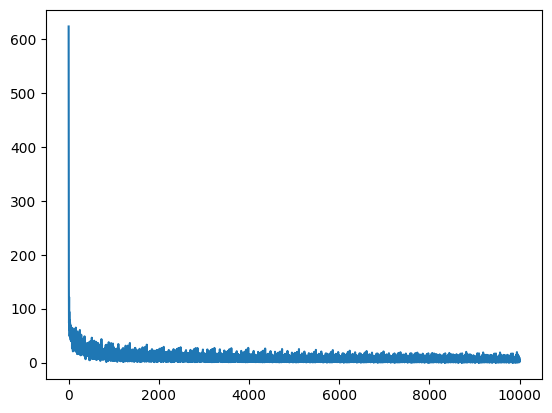

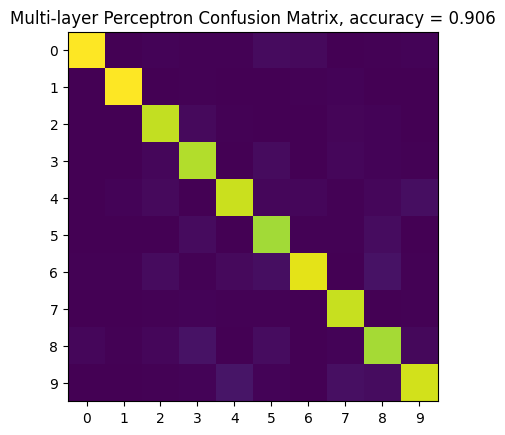

Iteration Number is :  0  Loss is :  0


KeyboardInterrupt: 

In [160]:
if __name__ == '__main__':
    # main_slp_linear()
    # main_slp()
    main_mlp()
    main_cnn()

In [129]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
# from cnn import get_mini_batch, fc, relu, conv, pool2x2, flattening
# from cnn import train_slp_linear, train_slp, train_mlp, train_cnn


def main_slp_linear():
    mnist_train = sio.loadmat('./mnist_train.mat')
    mnist_test = sio.loadmat('./mnist_test.mat')
    im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
    im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
    batch_size = 32
    im_train, im_test = im_train / 255.0, im_test / 255.0
    mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)
    w, b = train_slp_linear(mini_batch_x, mini_batch_y)
    sio.savemat('slp_linear.mat', mdict={'w': w, 'b': b})

    acc = 0
    confusion = np.zeros((10, 10))
    num_test = im_test.shape[1]
    for i in range(num_test):
        x = im_test[:, [i]]
        y = fc(x, w, b)
        l_pred = np.argmax(y)
        confusion[l_pred, label_test[0, i]] = confusion[l_pred, label_test[0, i]] + 1

        if l_pred == label_test[0, i]:
            acc = acc + 1
    accuracy = acc / num_test
    for i in range(10):
        confusion[:, i] = confusion[:, i] / np.sum(confusion[:, i])

    label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    visualize_confusion_matrix(confusion, accuracy, label_classes, 'Single-layer Linear Perceptron Confusion Matrix')

def main_slp():
    mnist_train = sio.loadmat('./mnist_train.mat')
    mnist_test = sio.loadmat('./mnist_test.mat')
    im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
    im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
    batch_size = 32
    im_train, im_test = im_train / 255.0, im_test / 255.0
    mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)
    w, b = train_slp(mini_batch_x, mini_batch_y)
    sio.savemat('slp.mat', mdict={'w': w, 'b': b})

    acc = 0
    confusion = np.zeros((10, 10))
    num_test = im_test.shape[1]
    for i in range(num_test):
        x = im_test[:, [i]]
        y = fc(x, w, b)
        l_pred = np.argmax(y)
        confusion[l_pred, label_test[0, i]] = confusion[l_pred, label_test[0, i]] + 1

        if l_pred == label_test[0, i]:
            acc = acc + 1
    accuracy = acc / num_test
    for i in range(10):
        confusion[:, i] = confusion[:, i] / np.sum(confusion[:, i])

    label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    visualize_confusion_matrix(confusion, accuracy, label_classes, 'Single-layer Perceptron Confusion Matrix')

def main_mlp():
    mnist_train = sio.loadmat('./mnist_train.mat')
    mnist_test = sio.loadmat('./mnist_test.mat')
    im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
    im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
    batch_size = 32
    im_train, im_test = im_train / 255.0, im_test / 255.0
    mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)
    w1, b1, w2, b2 = train_mlp(mini_batch_x, mini_batch_y)
    sio.savemat('mlp.mat', mdict={'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2})

    acc = 0
    confusion = np.zeros((10, 10))
    num_test = im_test.shape[1]
    for i in range(num_test):
        x = im_test[:, [i]]
        pred1 = fc(x, w1, b1)
        pred2 = relu(pred1)
        y = fc(pred2, w2, b2)
        l_pred = np.argmax(y)
        confusion[l_pred, label_test[0, i]] = confusion[l_pred, label_test[0, i]] + 1

        if l_pred == label_test[0, i]:
            acc = acc + 1
    accuracy = acc / num_test
    for i in range(10):
        confusion[:, i] = confusion[:, i] / np.sum(confusion[:, i])

    label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    visualize_confusion_matrix(confusion, accuracy, label_classes, 'Multi-layer Perceptron Confusion Matrix')

def main_cnn():
    mnist_train = sio.loadmat('./mnist_train.mat')
    mnist_test = sio.loadmat('./mnist_test.mat')
    im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
    im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
    batch_size = 32
    im_train, im_test = im_train / 255.0, im_test / 255.0
    mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)
    w_conv, b_conv, w_fc, b_fc = train_cnn(mini_batch_x, mini_batch_y)
    sio.savemat('cnn.mat', mdict={'w_conv': w_conv, 'b_conv': b_conv, 'w_fc': w_fc, 'b_fc': b_fc})
    # could use following two lines to replace above two lines if only want to check results
    # data = sio.loadmat('cnn.mat')
    # w_conv, b_conv, w_fc, b_fc = data['w_conv'], data['b_conv'], data['w_fc'], data['b_fc']
    
    acc = 0
    confusion = np.zeros((10, 10))
    num_test = im_test.shape[1]
    for i in range(num_test):
        x = im_test[:, [i]].reshape((14, 14, 1), order='F')
        pred1 = conv(x, w_conv, b_conv)  # (14, 14, 3)
        pred2 = relu(pred1)  # (14, 14, 3)
        pred3 = pool2x2(pred2)  # (7, 7, 3)
        pred4 = flattening(pred3)  # (147, 1)
        y = fc(pred4, w_fc, b_fc)  # (10, 1)
        l_pred = np.argmax(y)
        confusion[l_pred, label_test[0, i]] = confusion[l_pred, label_test[0, i]] + 1
        if l_pred == label_test[0, i]:
            acc = acc + 1
    accuracy = acc / num_test
    for i in range(10):
        confusion[:, i] = confusion[:, i] / np.sum(confusion[:, i])

    label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    visualize_confusion_matrix(confusion, accuracy, label_classes, 'CNN Confusion Matrix')

def visualize_confusion_matrix(confusion, accuracy, label_classes, name):
    plt.title("{}, accuracy = {:.3f}".format(name, accuracy))
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    plt.show()


In [27]:
# if __name__ == '__main__':
#     main.main_slp_linear()
#     main.main_slp()
#     main.main_mlp()
#     main.main_cnn()